In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', '..', '..', 'notebook_format') )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size
plt.rcParams['font.size'] = 10 # and font size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

import warnings
from sklearn.datasets import fetch_20newsgroups
from scipy.optimize import linear_sum_assignment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn,scipy

Ethen 2016-11-25 14:30:58 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.2
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.18
scipy 0.18.1


# Stability Analysis for Topic Models

This documentation aims to reproduce the methodology from the paper [How Many Topics? Stability Analysis for Topic Models (2014) Derek Greene, Derek O'Callaghan, Pádraig Cunningham](https://arxiv.org/abs/1404.4606). In the paper, they proposed a topic stability method that tries to address the issue of choosing an appropriate topic number for performing topic modeling.


## Quick Review

The following two code chunks shows how to use scikit-learn's Latent Dirichlet Allocation to perform topic modeling. If you're still unfamiliar of what a topic modeling does, consider checking out a high level walkthrough [here](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/topic_model/LDA.ipynb).

In [3]:
# recent scikit-learn are raising deprecation warnings that
# default value for 'learning_method' will be changed 
# from 'online' to 'batch'; we won't worry about it
warnings.filterwarnings('ignore', category = DeprecationWarning) 

texts = ['human interface computer',
         'survey user computer system response time',
         'eps user interface system',
         'system human system eps',
         'user response time',
         'trees',
         'graph trees',
         'graph minors trees',
         'graph minors survey']


# convert to document-term matrix and train the lda model
vec = CountVectorizer(stop_words = 'english')
lda = LatentDirichletAllocation(n_topics = 2, learning_method = 'batch')
X_dtm = vec.fit_transform(texts)
doc_topic_distr = lda.fit_transform(X_dtm)

In [4]:
def print_top_words(vec, lda_model, n_top_words):
    """top words associated with each topic for sklearn's LDA"""
    features = vec.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print( 'Topic #{}:'.format(topic_idx) )
        
        # argsort sorts in increasing order, and we wish
        # toprint the last n words in decreasing order
        print( ', '.join([ features[i] for i in np.argsort(topic)[:-n_top_words - 1:-1] ]) )
        print()
    
    print()
    

# after training the model, we print the top words
# associated within each topic to interpret the model's result
n_top_words = 15
print_top_words(lda_model = lda, vec = vec, n_top_words = n_top_words)

Topic #0:
user, time, response, eps, computer, interface, human, survey, trees, graph, minors

Topic #1:
graph, trees, minors, survey, human, interface, computer, eps, user, response, time




## Term Ranking Similarity

Before getting into topic stability, we will need to have two basic ideas in mind:

- The stability of clustering model refers to its ability to consistently generate similar results when applying the same algorithm to the same data source.
- One common output that a topic model reports is the top terms (in the paper, they refer to it as a **ranked list**, hence we'll use top terms and ranked list interchangeably) associated with each topics.

Given these two piece of information, the idea behind topic stability is that we compare the similarity of the topic terms between different runs of the topic model to determine whether it is stable or not.

To formalize it a bit, the output of a topic modeling algorithm is in the form of a ranking set containing $k$ ranked lists, denoted $S = \{R_1,...,R_k\}$. The $i_{th}$ topic produced by the algorithm is represented by the list $R_i$ ($k$ is simply the topic number that we specified, in the sklearn API, this is `n_topics`), containing the top $t$ terms which are most representative of that topic. Usually $t$ is within the range of 10 to 20.

Now that we've obtained the ranked list, a naive approach to assess the similarity between a pair of ranked lists $R_i, R_j$ would be to employ a simple similarity such as the **Jaccard similarity**. 

However, such measures do not take into account positional information, that is terms occurring at the top of a ranked list generated by a topic model algorithm such as LDA will naturally be more relevant to a topic than those occurring at the tail of the list. Also, in practice, rather than considering all $m$ terms in a corpus, it may be preferable to use only the top $t << m$ terms to represent the ranked list.

Therefore, we instead use of a weighted version of the Jaccard index, suitable for calculating the similarity between pairs of indefinite rankings. Specifically, we define the **Average Jaccard (AJ)** measure as follows. We calculate the average of the Jaccard scores between every pair of subsets of d top-ranked terms in two lists, for depth $d \in [1, t]$. That is:

\begin{equation} 
AJ(R_i, R_j) = \frac{1}{t} \sum_{d = 1}^t \gamma_d (R_i, R_j)
\end{equation}

Where:

\begin{equation}
\gamma_d (R_i, R_j) = \frac{ \rvert R_{i, d} \cap R_{j, d} \rvert }{ \rvert R_{i, d} \cup R_{j, d} \rvert }
\end{equation}

such that $R_{i,d}$ is the head of list $R_i$ up to depth $d$. This is a symmetric measure producing values in the range [0,1], where the terms in the ranked list are weighted according to a decreasing linear scale. To demonstrate this, a simple illustrative example is shown below.

<img src="img/jaccard.png" height="70%" width="70%">

Note that, although the Jaccard score at depth $d = 5$ is comparatively high (0.429), the Average Jaccard score is much lower (0.154), as the similarity between terms occurs towards the tails of the lists – these terms carry less weight than those at the head of the lists, such as "album" and "sport".

The following code chunk reproduces the results from the table.

In [5]:
R1 = [
    ['album'],
    ['album', 'music'],
    ['album', 'music', 'best'],
    ['album', 'music', 'best', 'award'],
    ['album', 'music', 'best', 'award', 'win']
]

R2 = [
    ['sport'],
    ['sport', 'best'],
    ['sport', 'best', 'win'],
    ['sport', 'best', 'win', 'medal'],
    ['sport', 'best', 'win', 'medal', 'award']
]

In [6]:
def compute_jaccard(ranking1, ranking2):
    """
    compute jaccard similarity that does not take into account 
    rank positions and indefinite list
    """
    set1 = set(ranking1)
    set2 = set(ranking2)
    numerator = len( set1.intersection(set2) )
    if not numerator:
        return 0

    denominator = len( set1.union(set2) )
    jaccard_sim = numerator / denominator
    return jaccard_sim

In [7]:
def compute_avg_jaccard(ranking1, ranking2):
    """
    weighted version of jaccard similarity, 
    which takes into account rank positions
    """
    total = 0
    k = len(ranking1)
    for i in range(1, k + 1):
        total += compute_jaccard( ranking1[:i], ranking2[:i] )
        
    avg_jaccard_sim = total / k
    return avg_jaccard_sim

In [8]:
# test it for the final depth
ranking1 = R1[4]
ranking2 = R2[4]
jaccard = compute_jaccard(ranking1, ranking2)
avg_jaccard = compute_avg_jaccard(ranking1, ranking2)
print('jaccard:', jaccard)
print('average jaccard:', avg_jaccard)

jaccard: 0.42857142857142855
average jaccard: 0.15428571428571428


## Topic Model Agreement

Now that we have a similarity metric for the top-terms, we move on to the problem of measuring the agreement between two different $k$-way topic models, represented as two ranking sets $S_x = \{ R_{x1}, ..., R_{xk} \}$ and $S_y = \{ R_{y1}, ..., R_{yk} \}$, both containing $k$ ranked lists. We construct a $k × k$ similarity matrix $M$, such that the entry $M_{ij}$ indicates the agreement between $R_{xi}$ and $R_{yj}$ (i.e. the i-th topic in the first model and the j-th topic in the second model), as calculated using the Average Jaccard score. We then find the best match between the rows and columns of $M$ (pairs that have the highest similarity between the two ranked set), or so called the optimal permutation, denoted as $\pi$. From this we can product an agreement score:

\begin{equation}
agree(S_x, S_y) = \frac{1}{k} \sum_{i = 1}^k AJ \big( R_{xi}, \pi(R_{xi}) \big)
\end{equation}

Where $\pi(R_{xi})$ denotes the ranked list in $S_y$ matched to $R_{xi}$ by the permutation $\pi$. Hungarian method is to find the optimal permutation, The slides from [The Assignment Problem and the Hungarian Method](http://www.math.harvard.edu/archive/20_spring_05/handouts/assignment_overheads.pdf) contains more details of this method.

A simple example illustrating the agreement process is shown below Fig. 1.

<img src="img/agreement.png" height="70%" width="70%">

In [9]:
# compare between two ranking the set
# where the length of the set is simply
# the number of topics in each topic model
S1 = [
    ['sport', 'win', 'award'],
    ['bank', 'finance', 'money'],
    ['music', 'album', 'band']
]

S2 = [
    ['finance', 'bank', 'economy'],
    ['music', 'band', 'award'],
    ['win', 'sport', 'money']
]

In [10]:
# reproduce the similarity matrix
n_topic = len(S1)
sim_mat = np.zeros(( n_topic, n_topic ))
for row in range(n_topic):  
    for col in range(n_topic):
        sim_mat[row, col] = compute_avg_jaccard(S1[row], S2[col])

sim_mat

array([[ 0.        ,  0.06666667,  0.5       ],
       [ 0.5       ,  0.        ,  0.06666667],
       [ 0.        ,  0.61111111,  0.        ]])

In [11]:
# solve for the optimal permutation using hungarian algorithm,
# for the scipy implementation, each element is presented as cost
# hence we take the negative sign of the similarity matrix
row_ind, col_ind = linear_sum_assignment(-sim_mat)
agreement = np.mean( sim_mat[row_ind, col_ind] )
agreement

0.53703703703703709

In [12]:
# simply wrapping all of it in one function
def compute_agreement(S1, S2):
    """
    measuring the agreement between two different 
    k-way topic models, represented as two rank sets;
    the rank set is simply the top words for each topic
    """
    
    # compute the similarity matrix
    n_topic = len(S1)
    sim_mat = np.zeros(( n_topic, n_topic ))
    for row in range(n_topic):
        for col in range(n_topic):
            sim_mat[row, col] = compute_avg_jaccard(S1[row], S2[col])    
    
    # solve for the optimal permutation using hungarian algorithm,
    # for the scipy implementation, each element is presented as cost
    # hence we use the negative sign of the similarity matrix as input
    row_ind, col_ind = linear_sum_assignment(-sim_mat)
    agreement = np.mean( sim_mat[row_ind, col_ind] )
    return agreement

In [13]:
agreement = compute_agreement(S1, S2)
agreement

0.53703703703703709

## Selecting the Number of Topics

Building on top of the agreement score, the topic number selction process is defined as follows:

- Randomly generate $\gamma$ samples of the full corpus, each containing $\beta \times n$ documents. $n$ denotes the total number of documents, and $\beta$ is $0 < \beta < 1$ denotes the sampling ratio controlling the number of documents in each sample. For this step, we'll also try out taking a bootstrap sample, where instead of sampling $\beta \times n$ documents, we'll sample $n$ documents, but with replacement. The reason for wanting to give this method a shot is inspired by the fact that this method is also used in algorithms like Randomforest and it is also used in the R package [fpc](https://cran.r-project.org/web/packages/fpc/fpc.pdf) to access the stability of clustering algorithms.
- For each value of $k \in [kmin, kmax]$ (a defined range of topic numbers to search for):
    - Apply the topic modeling algorithm to the complete data set of $n$ documents to generate $k$ topics, and represent the output as the reference ranking set $S_0$.
    - For each sample $\gamma$:
        - Apply the topic modeling algorithm to it to generate $k$ topics, and represent the output as the ranking set $S_i$. 
        - Calculate the agreement score agree ($S_0$, $S_i$).
    - Compute the mean agreement score for $k$ over all $\gamma$ samples. This measure is the overall topic stability at $k$ topics.
    
After going through the whole process, we can examine the plot of the stability scores ranging from $[kmin, kmax]$ and the optimal value for $k$ may be identified based on peaks in the plot. Or simply use the program to select the maximum stability score.

In [14]:
import spacy
import multiprocessing
from gensim.models import Phrases
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.word2vec import LineSentence
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS


from numba import jit
from tqdm import tqdm_notebook
from operator import itemgetter
from gensim.models.ldamulticore import LdaMulticore

## Preprocessing

We'll now try this Topic Stability using a larger dataset (sample wikipedia text file). To follow along please download the file from this [link](https://www.dropbox.com/s/mriz0nq35ore8cr/people_wiki.csv?dl=0).

This section focuses on preprocessing our text data by:

- Obtaining one set of stop words. Stop words are very common words, like _a_, _the_, _and_, and so on, that serve functional roles in the English language, but typically don't contribute too much to the overall meaning of text. Filtering stopwords is a common procedure that allows text modeling or natural language processing techniques to focus on the words that carry more semantic weight.
- Perform lemmatization, remove stop words, punctuation, whitespace, numbers

After performing all of that task, we'll write out the cleaned text to disk.

In [15]:
df_data = []
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
for category in categories:
    data_dir = os.path.join('bbc', category)
    data_files = os.listdir(data_dir)

    data = []
    for file in data_files:
        data_path = os.path.join(data_dir, file)
        with open(data_path, encoding = 'latin-1') as f:
            text = f.readlines()
            sentence = ' '.join(text)
            data.append(sentence)
        
    df = pd.DataFrame( data, columns = ['text'] )
    df['category'] = category
    df_data.append(df)

In [16]:
# shuffle the rows
data = pd.concat(df_data)
data = data.sample(frac = 1)
X = data['text']

print( 'number of documents', X.shape[0] )
data.head()

number of documents 2225


,text,category
467,Classy Henman makes winning start\n \n Tim Hen...,sport
445,Davenport dismantles young rival\n \n Top seed...,sport
146,Malaysia lifts Islamic bank limit\n \n Malaysi...,business
388,Mobile multimedia slow to catch on\n \n There ...,tech
52,Microsoft launches its own search\n \n Microso...,tech


The next code chunk join all the stopwords set, including the built-in set from scikit-learn and spacy and the one that we manually found. Here we're only including a few words/symbols, but what we can do is: specify a list in a .csv file and read it in from disk. After that we can increase the words in the .csv file by training a LDA model, and remove unhelpful words that appeared in the top words of each topic (do this iteratively until we're satisfied with the result).

In [17]:
spacy_stopwords = spacy.en.language_data.STOP_WORDS
stopwords = set(["'s", 'mr', 'want', 'year', 'way', '\n', "'", 'good'])
stopwords = stopwords | set(ENGLISH_STOP_WORDS) | spacy_stopwords
print( 'number of stop words:', len(stopwords) )

number of stop words: 346


In [18]:
def create_generator(X):
    """observation generator for spaCy's streaming preprocessing"""
    for x in X:
        yield x
        

def is_word(token):
    """whether the spacy token is a punctuation, whitespace or number"""    
    return not (token.is_punct or token.is_space or token.like_num)


def lemmatize_corpus(X, stopwords):
    """
    generator function to use spaCy to parse reviews,
    lemmatize the text, remove punctuation, whitespace
    and number; after that yield the cleaned text
    to write out to a text file
    """
    
    # use the .pip to process texts as a stream;
    # this functionality supports using multi-threads,
    # these parameters, including the batch size and
    # the thread number to use (all available - 1)
    # are hard-coded
    nlp = spacy.load('en')
    workers = multiprocessing.cpu_count() - 1
    for text in nlp.pipe( create_generator(X), 
                          batch_size = X.shape[0] // workers, 
                          n_threads = workers ):  
        tokens = []
        for token in text:
            if is_word(token) and token.lemma_ not in stopwords:
                tokens.append(token.lemma_)
        
        cleaned_text = ' '.join(tokens)
        yield cleaned_text
        

def export_unigrams(unigram_path, X, stopwords):
    """
    clean up the text and export it to a .txt file,
    where each line is one observation
    """
    with open(unigram_path, 'w', encoding = 'utf_8') as f:
        for cleaned_text in lemmatize_corpus(X, stopwords):
            f.write(cleaned_text + '\n')

In [19]:
data_dir = 'data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

unigram_path = os.path.join(data_dir, 'unigram.txt')
if not os.path.exists(unigram_path):  
    export_unigrams(unigram_path, X, stopwords)

After exporting the cleaned unigram to .txt file, the code chunk below makes sure that the document number matches.

In [20]:
def count_file_len(file_name):
    """
    count the total number of lines for a given file
    http://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python
    """
    with open(file_name) as f:
        for i, _ in enumerate(f, 1):
            pass
    return i

file_len = count_file_len(unigram_path)
print(file_len)

2225


## Modeling

This part consists of four stages:

- Build a **Phrase Model** to detect common multi-word expressions. So instead of naively creating bigrams from the token, this will only create the bigram that are more likely to be considered as bigrams. e.g. in the sentence "i like ice cream", we hope that after training the model, only ice cream will be glued together as one word ice_cream, instead of creating three bigrams such as i_like, like_ice, ice_cream
- Build up a dictionary of the words that exists in the entire corpora. For this part, we removed words that appear less than 2 documents, appear in more than 90% of the document and restricted the number of words/features to be only 20% of the number of training data (document count)
- Train the Topic Stability model, to determine the optimal topic number for the LDA model
- Use the optimal topic number to train the LDA model


### Phrase Model

A little bit more detail on the Phrase Model section. The gist of Phrase Model is to loop over the words in our texts and looking for words that _co-occur_ (i.e., appear one after another) together much more frequently than you would expect them to by random chance. To determine whether two tokens $A$ and $B$ forms a phrase, gensim's [**Phrases**](https://radimrehurek.com/gensim/models/phrases.html) model uses the formula:

$$\frac{count(A\ B) - count_{min}}{count(A) \times count(B)} \times N > threshold$$

where:

* $count(A)$ is the number of times token $A$ appears in the corpus
* $count(B)$ is the number of times token $B$ appears in the corpus
* $count(A\ B)$ is the number of times the tokens $A\ B$ appear in the corpus *in order*
* $N$ is the total size of the corpus vocabulary
* $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
* $threshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase

Once our Phrase Model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token. Note that there is nothing stopping us from applying multiple iteration of the phrase model. This means after we perform the first phrase model to create the bigram from the unigram, we can use the bigram train a second phrase model that learns the trigram, but we'll stop at bigram for now.

In [21]:
def train_phrase_model(unigram_path, bigram_model_path, lines):
    """
    stream the unigram text file and
    train the phrase model to train the bigrams
    from the unigrams and also save it to disk;
    """
    
    # use LineSetence to stream text
    unigram_sentences = LineSentence(unigram_path, max_sentence_length = lines)
    bigram_model = Phrases(unigram_sentences)
    bigram_model.save(bigram_model_path)
    return bigram_model

In [22]:
# create a directory called 'model' to
# store all models in later section
model_dir = 'model'
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)


bigram_model_path = os.path.join(model_dir, 'bigram_model')
if os.path.exists(bigram_model_path):
    bigram_model = Phrases.load(bigram_model_path)
else:
    lines = X.shape[0]
    bigram_model = train_phrase_model(unigram_path, bigram_model_path, lines)

In [23]:
def export_bigrams(unigram_path, bigram_path, phrase_model):
    """
    use the learned phrase model to create (potential) bigrams,
    and output the text that contains bigrams to disk
    """
    with open(bigram_path, 'w') as output_f:
        with open(unigram_path) as input_f:
            for text in input_f:
                unigram = text.split()

                # after training the Phrase model, it will 
                # transform any sentence (list of token strings)
                # and glue unigrams together into bigrams
                bigram = phrase_model[unigram]
                bigram_sentence = ' '.join(bigram)
                output_f.write(bigram_sentence + '\n')

In [24]:
bigram_path = os.path.join(data_dir, 'bigram.txt')
if not os.path.exists(bigram_path):
    export_bigrams(unigram_path, bigram_path, bigram_model)

The next code chunk might be a bit odd, because we're switching from gensim's api to scikit-learn's api. This is because, as the time of writing this, the TopicStability accessment was written for scikit-learn's `LatentDirichletAllocation`. Supporting different packages' LDA model is definitely possible, but we'll leave this as a future task.

In [25]:
X = []
with open(bigram_path) as f:
    for text in f:
        X.append(text)

X = np.array(X)
vec = CountVectorizer(min_df = 5, max_df = 0.6, max_features = 1000)
workers = multiprocessing.cpu_count() - 1
lda = LatentDirichletAllocation(learning_method = 'batch', n_jobs = workers)

In [26]:
from topic_stability import TopicStability

n_top_words = 20
n_topics_range = [4, 5, 7, 10]
n_sample_frac = 0.8
n_sample_time = 4
bootstrap = False

ts = TopicStability(
    vec = vec, 
    lda_model = lda, 
    n_top_words = n_top_words, 
    n_topics_range = n_topics_range,
    n_sample_time = n_sample_time,
    n_sample_frac = n_sample_frac,
    bootstrap = bootstrap
)
ts.fit(X)
print('best number of topic:', ts.best_n_topic)

best number of topic: 5


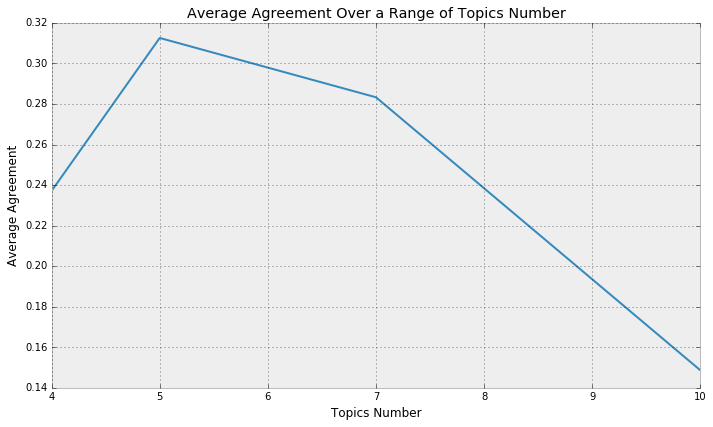

In [27]:
fig = plt.figure( figsize = (10, 6) )
plt.plot(ts.n_topics_range, ts.avg_agreements)
plt.title('Average Agreement Over a Range of Topics Number')
plt.ylabel('Average Agreement')
plt.xlabel('Topics Number')
plt.tight_layout()

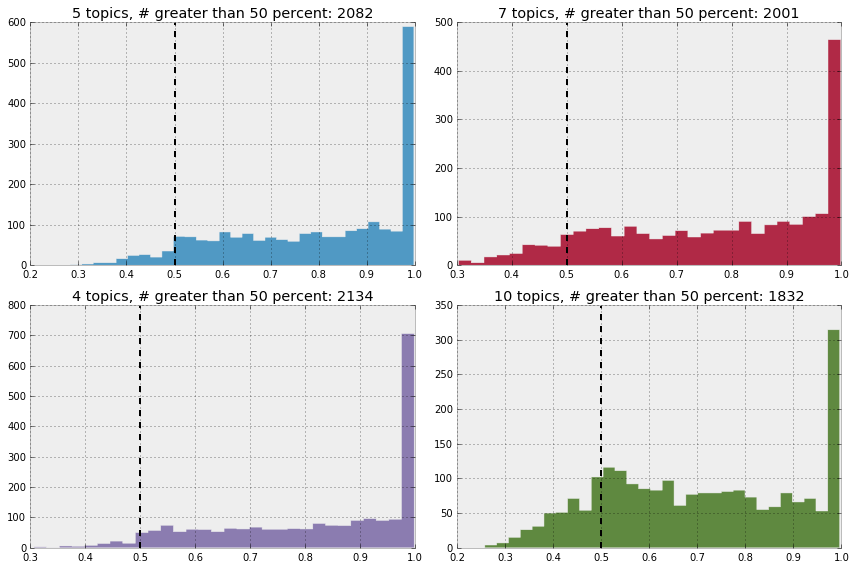

In [28]:
fig = plt.figure( figsize = (12, 8) )

# for acessing the color cycle
# http://stackoverflow.com/questions/34247297/matplotlib-1-5-usage-of-axes-prop-cycle
colors = list(plt.rcParams['axes.prop_cycle'])

# visualize only four topics number's maximum probability
# (probability of belonging in the most likely topic)
# the best, the worst, and two in the middle
arg_sorted = np.argsort(ts.avg_agreements)
half = ( len(n_topics_range) - 1 ) // 2
plot_topics = arg_sorted[len(n_topics_range) - 1], arg_sorted[half + 1], arg_sorted[half], arg_sorted[0]

for idx, k in enumerate(plot_topics): 
    plt.subplot(2, 2, idx + 1)    
    prob = ts.max_probs[k]
    
    # for that topic number count the number of 
    # documents that have maximum probability greater than 50%
    greater_than_50 = np.sum(prob > 0.5)
    plt.hist( prob, histtype = 'stepfilled', alpha = 0.85, 
              color = colors[idx]['color'], bins = 30 )
    plt.title( '{} topics, # greater than 50 percent: {}'.format( ts.n_topics_range[k], greater_than_50 ) )
    plt.axvline(x = 0.5, color = 'black', linestyle = '--')

fig.tight_layout()

In [29]:
def create_bow_generator(textfile_path, lines, dictionary_path):
    """
    read reviews from a file
    and yield a bag-of-words representation
    """
    # 1. create the generator to read streaming file
    # 2. create the dictionary to filter tokens that are very rare or 
    # too common from the dictionary (filter_extremes), these parameters
    # are hard-coded and reassign integer ids (compactify)
    bigram_sentences = LineSentence(textfile_path, max_sentence_length = lines)
    bigram_dictionary = Dictionary(bigram_sentences)
    bigram_dictionary.filter_extremes(no_below = 5, no_above = 0.6, keep_n = 1000)
    bigram_dictionary.compactify()
    bigram_dictionary.save(dictionary_path)
    print( 'vocab size:', len(bigram_dictionary) )
    
    for text in bigram_sentences:
        yield bigram_dictionary.doc2bow(text)

In [30]:
corpus_path = os.path.join(model_dir, 'bigram_bow.mm')
dictionary_path = os.path.join(model_dir, 'bigram_dictionary.dict')

if os.path.exists(corpus_path):
    corpus = MmCorpus(corpus_path)
else:
    
    # keep 50% of the features
    lines = X.shape[0]
    # keep_n = lines // 2
    MmCorpus.serialize( corpus_path, 
                        create_bow_generator(bigram_path, lines, dictionary_path) )
    corpus = MmCorpus(corpus_path)
    
print( 'corpus size:', len(corpus) )

vocab size: 1000
corpus size: 2225


In [31]:
n_topics = 5
lda_model_path = os.path.join(model_dir, 'lda_model') 
if os.path.exists(lda_model_path):
    lda = LdaMulticore.load(lda_model_path)
else:
    # workers => sets the parallelism, and should be
    # set to your number of physical cores minus one
    # as suggested by gensim
    workers = multiprocessing.cpu_count() - 1
    
    # load the finished dictionary from disk
    bigram_dictionary = Dictionary.load(dictionary_path)
    
    # train the LDA model;
    # `passes` is the number of training passes through the corpus. For 
    # example, if the training corpus has 50,000 documents, chunksize is 
    # 10,000, passes is 2, then online training is done in 10 update
    # `iterations` the maximum number of iterations allowed 
    lda = LdaMulticore(
        corpus,
        num_topics = n_topics,
        id2word = bigram_dictionary,
        workers = workers
    )
    lda.save(lda_model_path)

In [32]:
# print out the per topic word probability to interpret the result
lda.show_topics(num_topics = n_topics, num_words = 30)

[(0,
  '0.009*new + 0.009*time + 0.008*win + 0.007*game + 0.007*come + 0.007*people + 0.006*use + 0.006*firm + 0.006*film + 0.006*work + 0.005*need + 0.005*big + 0.005*party + 0.005*add + 0.005*play + 0.004*government + 0.004*company + 0.004*think + 0.004*share + 0.004*player + 0.004*include + 0.004*market + 0.004*$ + 0.004*week + 0.004*set + 0.004*like + 0.004*help + 0.004*report + 0.004*end + 0.004*uk'),
 (1,
  '0.010*company + 0.007*government + 0.007*people + 0.007*new + 0.007*$ + 0.006*plan + 0.006*game + 0.006*use + 0.005*tax + 0.005*election + 0.005*offer + 0.005*sale + 0.005*firm + 0.005*brown + 0.005*like + 0.004*day + 0.004*world + 0.004*time + 0.004*week + 0.004*play + 0.004*labour + 0.004*change + 0.004*come + 0.004*add + 0.004*right + 0.004*service + 0.004*pay + 0.004*win + 0.004*help + 0.004*need'),
 (2,
  '0.012*use + 0.008*time + 0.007*new + 0.007*people + 0.007*game + 0.007*win + 0.006*government + 0.006*play + 0.005*think + 0.005*number + 0.005*set + 0.005*club + 0.00

In [33]:
haha

NameError: name 'haha' is not defined

In [ ]:
# labeling the topics
topic_names = {
    0: ,      
    1: ,
    2: ,
    3: ,
    4: ,            
    5: 'politics',
    6: 'art',
    7: 'sport',  
    8: ,
    9: 'music'
}

In [ ]:
topic 0: Science and research
topic 1: Team sports
topic 2: Music, TV, and film
topic 3: American college and politics
topic 4: General politics
topic 5: Art and publishing
topic 6: Business
topic 7: International athletics
topic 8: Great Britain and Australia
topic 9: International musi

## Generating Outputs

We will export two .csv files. One that contains the guid and it's corresponding category. Another that summarize the categories identified by topic model, including the total count and the pecentage in the total dataset.

In [ ]:
# will be included in the topic summary output 
topic_count = np.bincount(output['category'])

# overwrite the topic number with the more descriptive topic names
output['category'] = output['category'].map(topic_names)
output = output.drop('fulldescription', axis = 1)


# create a directory called 'outputs' to
# store all outputs
OUTPUTS_DIR = os.path.join('..', 'outputs')
if not os.path.isdir(OUTPUTS_DIR):
    os.mkdir(OUTPUTS_DIR)

OUTPUT_TOPIC_PATH = os.path.join(OUTPUTS_DIR, 'assigned_topic.csv')
output.to_csv(OUTPUT_TOPIC_PATH, index = False)
output.head()

In [ ]:
output_category = pd.DataFrame({
    'count': topic_count,
    'percent': topic_count / np.sum(topic_count),
    'category': np.arange(n_topics)
}, columns = ['category', 'count', 'percent'] )
output_category['category'] = output_category['category'].map(topic_names)


OUTPUT_CATEGORY_PATH = os.path.join(OUTPUTS_DIR, 'category_info.csv')
output_category.to_csv(OUTPUT_CATEGORY_PATH, index = False)
output_category.head()

## Reference

- [Github: topic stability](https://github.com/derekgreene/topic-stability)
- [The Assignment Problem and the Hungarian Method](http://www.math.harvard.edu/archive/20_spring_05/handouts/assignment_overheads.pdf)
- [How Many Topics? Stability Analysis for Topic Models (2014) Derek Greene, Derek O'Callaghan, Pádraig Cunningham](https://arxiv.org/abs/1404.4606)